# Intro to ML - Final Project
## Shira Lavi (216006395), Omer Shadmi (327722575) & Emily Bederov (215025255)

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, mean_squared_error, recall_score, make_scorer
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import time
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

## Dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/EmilyBederov/Intro-To-ML/main/creditcardcsvpresentML.csv')
df

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
3070,6661273532,NaN,500.0,11000.0,Y,0,N,N,754,585.0,7,N
3071,6661273532,NaN,800.0,0.0,Y,0,N,N,754,585.0,7,N
3072,6661273533,NaN,800.0,20800.0,Y,0,N,N,754,585.0,7,N
3073,6661273532,NaN,1500.0,12000.0,Y,0,Y,Y,754,585.0,7,N


Some info about the data:
* The data was taken from a credit card company.
* The data has 3075 entries with 11 features and an additional column that indicates whether each transaction was fraudulent or not.
* now lets explore our features
* now lets explore our features

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Merchant_id                     3075 non-null   int64  
 1   Transaction date                0 non-null      float64
 2   Average Amount/transaction/day  3075 non-null   float64
 3   Transaction_amount              3075 non-null   float64
 4   Is declined                     3075 non-null   object 
 5   Total Number of declines/day    3075 non-null   int64  
 6   isForeignTransaction            3075 non-null   object 
 7   isHighRiskCountry               3075 non-null   object 
 8   Daily_chargeback_avg_amt        3075 non-null   int64  
 9   6_month_avg_chbk_amt            3075 non-null   float64
 10  6-month_chbk_freq               3075 non-null   int64  
 11  isFradulent                     3075 non-null   object 
dtypes: float64(4), int64(4), object(4)

In [4]:
#before mapping our features to numbers lets check for unique varibles
print("Unique values before mapping:")
print("Is declined:", df['Is declined'].unique())
print("isForeignTransaction:", df['isForeignTransaction'].unique())
print("isHighRiskCountry:", df['isHighRiskCountry'].unique())
print("isFradulent:", df['isFradulent'].unique())

Unique values before mapping:
Is declined: ['N' 'Y']
isForeignTransaction: ['Y' 'N']
isHighRiskCountry: ['Y' 'N']
isFradulent: ['Y' 'N']


### we see that in our numerical features, there arent 'non numerical' values. now lets convert the categorical data to numerical data.

In [5]:
# Mapping for binary categorical variables
mapping = {'Y': 1, 'N': 0}

df['Is declined'] = df['Is declined'].map(mapping)
df['isForeignTransaction'] = df['isForeignTransaction'].map(mapping)
df['isHighRiskCountry'] = df['isHighRiskCountry'].map(mapping)
df['isFradulent'] = df['isFradulent'].map(mapping)

df

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,3160040998,NaN,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,3160041896,NaN,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,3160141996,NaN,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,3160241992,NaN,500.0,26000.0,0,0,1,1,800,677.2,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3070,6661273532,NaN,500.0,11000.0,1,0,0,0,754,585.0,7,0
3071,6661273532,NaN,800.0,0.0,1,0,0,0,754,585.0,7,0
3072,6661273533,NaN,800.0,20800.0,1,0,0,0,754,585.0,7,0
3073,6661273532,NaN,1500.0,12000.0,1,0,1,1,754,585.0,7,0


now lets move on with exploring the data, show some plots, and statostical analysis

In [6]:
df.describe()

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
count,3.075000e+03,0.0,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000
mean,5.026634e+09,NaN,515.026556,9876.399210,0.018537,0.957398,0.229593,0.066667,55.737561,40.022407,0.391870,0.145691
std,9.870778e+08,NaN,291.906978,10135.331016,0.134903,2.192391,0.420640,0.249484,206.634779,155.968840,1.548479,0.352854
min,3.160041e+09,NaN,4.011527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.170814e+09,NaN,269.788047,2408.781147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.025578e+09,NaN,502.549575,6698.891856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.889625e+09,NaN,765.272803,14422.568935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.665906e+09,NaN,2000.000000,108000.000000,1.000000,20.000000,1.000000,1.000000,998.000000,998.000000,9.000000,1.000000


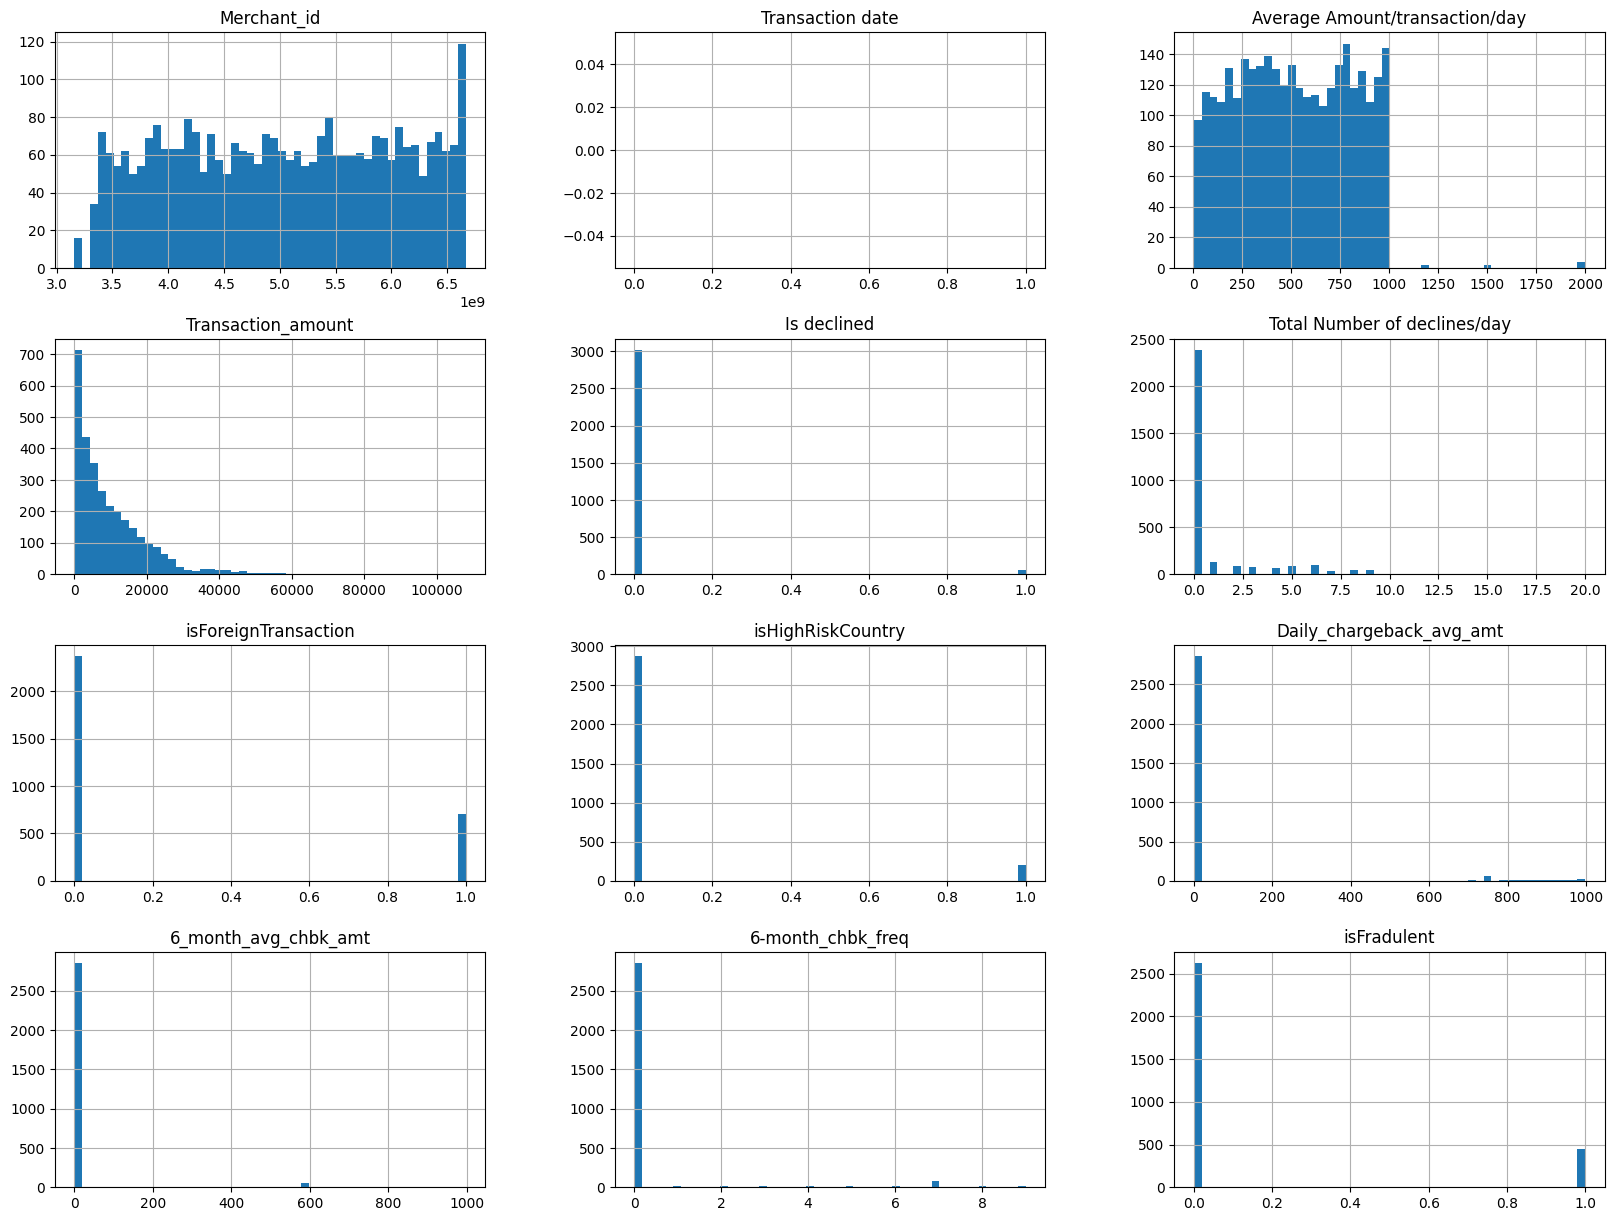

In [7]:
_ = df.hist(bins=50, figsize=(20,15))

* The column 'Merchant_id' is not important for our prediction,  we will delete this column.
* We see that 'Transiction date' is empty, all the column is nun, we will delete this column.
* The distribution of 'Average Amount/transaction/day' looks almost uniform in the erea of 0-1000 and it looks like there are some outliers at the erea of 1000-2000
* About 'Transaction_amount': we see that the most of the data in tihs column is 0, and the emount is going down as the 'Transaction_amount' is higher.
* About 'isFradulent' 'isForeignTransaction' most of the data is 0 - not a fraud, and a little part of the data is 1 - fraud
* About 'isFradulent' 'isHighRiskCountry' most of the data is 0 - not risky, and a little part of the data is 1 - risky
* For all the other column we see that most of the data is 0 and there are a little bit points that are spread (we will concider them as autliers)

In [8]:
df

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,3160040998,NaN,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,3160041896,NaN,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,3160141996,NaN,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,3160241992,NaN,500.0,26000.0,0,0,1,1,800,677.2,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3070,6661273532,NaN,500.0,11000.0,1,0,0,0,754,585.0,7,0
3071,6661273532,NaN,800.0,0.0,1,0,0,0,754,585.0,7,0
3072,6661273533,NaN,800.0,20800.0,1,0,0,0,754,585.0,7,0
3073,6661273532,NaN,1500.0,12000.0,1,0,1,1,754,585.0,7,0


moving on to
### Preprocessing:
* searching for duplicates
* Handaling missing values
* Encoding needed data
* Binning features
* Combinning features
* Removing Irrelavent features

checking for duplicate rows:

In [9]:
# Check for duplicate rows in the entire DataFrame
duplicates = df.duplicated(keep=False)

# Filter out the duplicate rows
duplicate_rows = df[duplicates]

# Display the shape and the duplicate rows
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
print("Duplicate rows:")
print(duplicate_rows)

Number of duplicate rows: 0
Duplicate rows:
Empty DataFrame
Columns: [Merchant_id, Transaction date, Average Amount/transaction/day, Transaction_amount, Is declined, Total Number of declines/day, isForeignTransaction, isHighRiskCountry, Daily_chargeback_avg_amt, 6_month_avg_chbk_amt, 6-month_chbk_freq, isFradulent]
Index: []


now, were moving on..

In [10]:
# missing values
missing_values_count = df.isnull().sum()
print(missing_values_count)

Merchant_id                          0
Transaction date                  3075
Average Amount/transaction/day       0
Transaction_amount                   0
Is declined                          0
Total Number of declines/day         0
isForeignTransaction                 0
isHighRiskCountry                    0
Daily_chargeback_avg_amt             0
6_month_avg_chbk_amt                 0
6-month_chbk_freq                    0
isFradulent                          0
dtype: int64


we will eliminate 'Transaction date' - Since everything is missing
- also we will eliminate id, doesnt have any affect on the fraud detaction

In [11]:
df = df.drop(columns='Transaction date', axis=1)
df = df.drop(columns='Merchant_id', axis=1)

lets dig dipper, lets search for negative values which are obviously are missing values. and as we said this step is done only on our train dataset.

In [12]:
def check_values(df, columns):
   
    results = {}
    for col in columns:
        negative_values_count = (df[col] < 0).sum()
        results[col] = {
            'negative_values_count': negative_values_count
        }
    return results

# List of columns to check
columns_to_check = ['Average Amount/transaction/day', 'Transaction_amount', 'Is declined', 'Total Number of declines/day', 'isForeignTransaction', 'isHighRiskCountry','Daily_chargeback_avg_amt', '6_month_avg_chbk_amt', '6-month_chbk_freq', 'isFradulent']

values_check = check_values(df, columns_to_check)
print("Negative val in training Dataset:")
for col, checks in values_check.items():
    print(f"Column: {col} - Negative Values: {checks['negative_values_count']}")

Negative val in training Dataset:
Column: Average Amount/transaction/day - Negative Values: 0
Column: Transaction_amount - Negative Values: 0
Column: Is declined - Negative Values: 0
Column: Total Number of declines/day - Negative Values: 0
Column: isForeignTransaction - Negative Values: 0
Column: isHighRiskCountry - Negative Values: 0
Column: Daily_chargeback_avg_amt - Negative Values: 0
Column: 6_month_avg_chbk_amt - Negative Values: 0
Column: 6-month_chbk_freq - Negative Values: 0
Column: isFradulent - Negative Values: 0


we can move forward -> lets handle outliers.

In [13]:
def detect_outliers_iqr(df):
    outlier_dict = {}  # To store outliers and their counts for each column
    for column in df.columns:  
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR

        # Identifying outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        if not outliers.empty:
            outlier_dict[column] = {'outliers': outliers.tolist(), 'count': len(outliers)}
        else:
            outlier_dict[column] = {'outliers': "No outliers detected", 'count': 0}

    return outlier_dict

outliers_dict = detect_outliers_iqr(df)

print("Number of Outliers from IQR method:")
for column, info in outliers_dict.items():
    print(f"{column}: {info['count']}")

for column, info in outliers_dict.items():
        print(f"Outliers from IQR method for {column}: {info}")

Number of Outliers from IQR method:
Average Amount/transaction/day: 4
Transaction_amount: 113
Is declined: 57
Total Number of declines/day: 691
isForeignTransaction: 706
isHighRiskCountry: 205
Daily_chargeback_avg_amt: 218
6_month_avg_chbk_amt: 218
6-month_chbk_freq: 218
isFradulent: 448
Outliers from IQR method for Average Amount/transaction/day: {'outliers': [2000.0, 2000.0, 2000.0, 2000.0], 'count': 4}
Outliers from IQR method for Transaction_amount: {'outliers': [39858.59905, 42652.3736, 36692.35941, 44531.9843, 38076.65874, 43444.04819, 33359.44532, 40454.5334, 37830.3206, 53116.92799, 39016.11702, 46789.84691, 43533.83346, 46067.5262, 52304.76611, 37403.54317, 44344.78686, 44646.97264, 46974.26042, 35941.06769, 37414.54867, 41654.95372, 33170.20285, 46035.33636, 39774.31547, 39487.05127, 41671.40658, 50848.20441, 32507.86462, 44113.33625, 35081.58671, 47239.55311, 33240.30626, 50338.30212, 40080.00063, 36363.98968, 42160.82011, 51641.84407, 34041.237, 56354.53925, 37431.79458, 33

## In our categorical data, there is an extreme number of outliers, lets plot our data, for better understanding

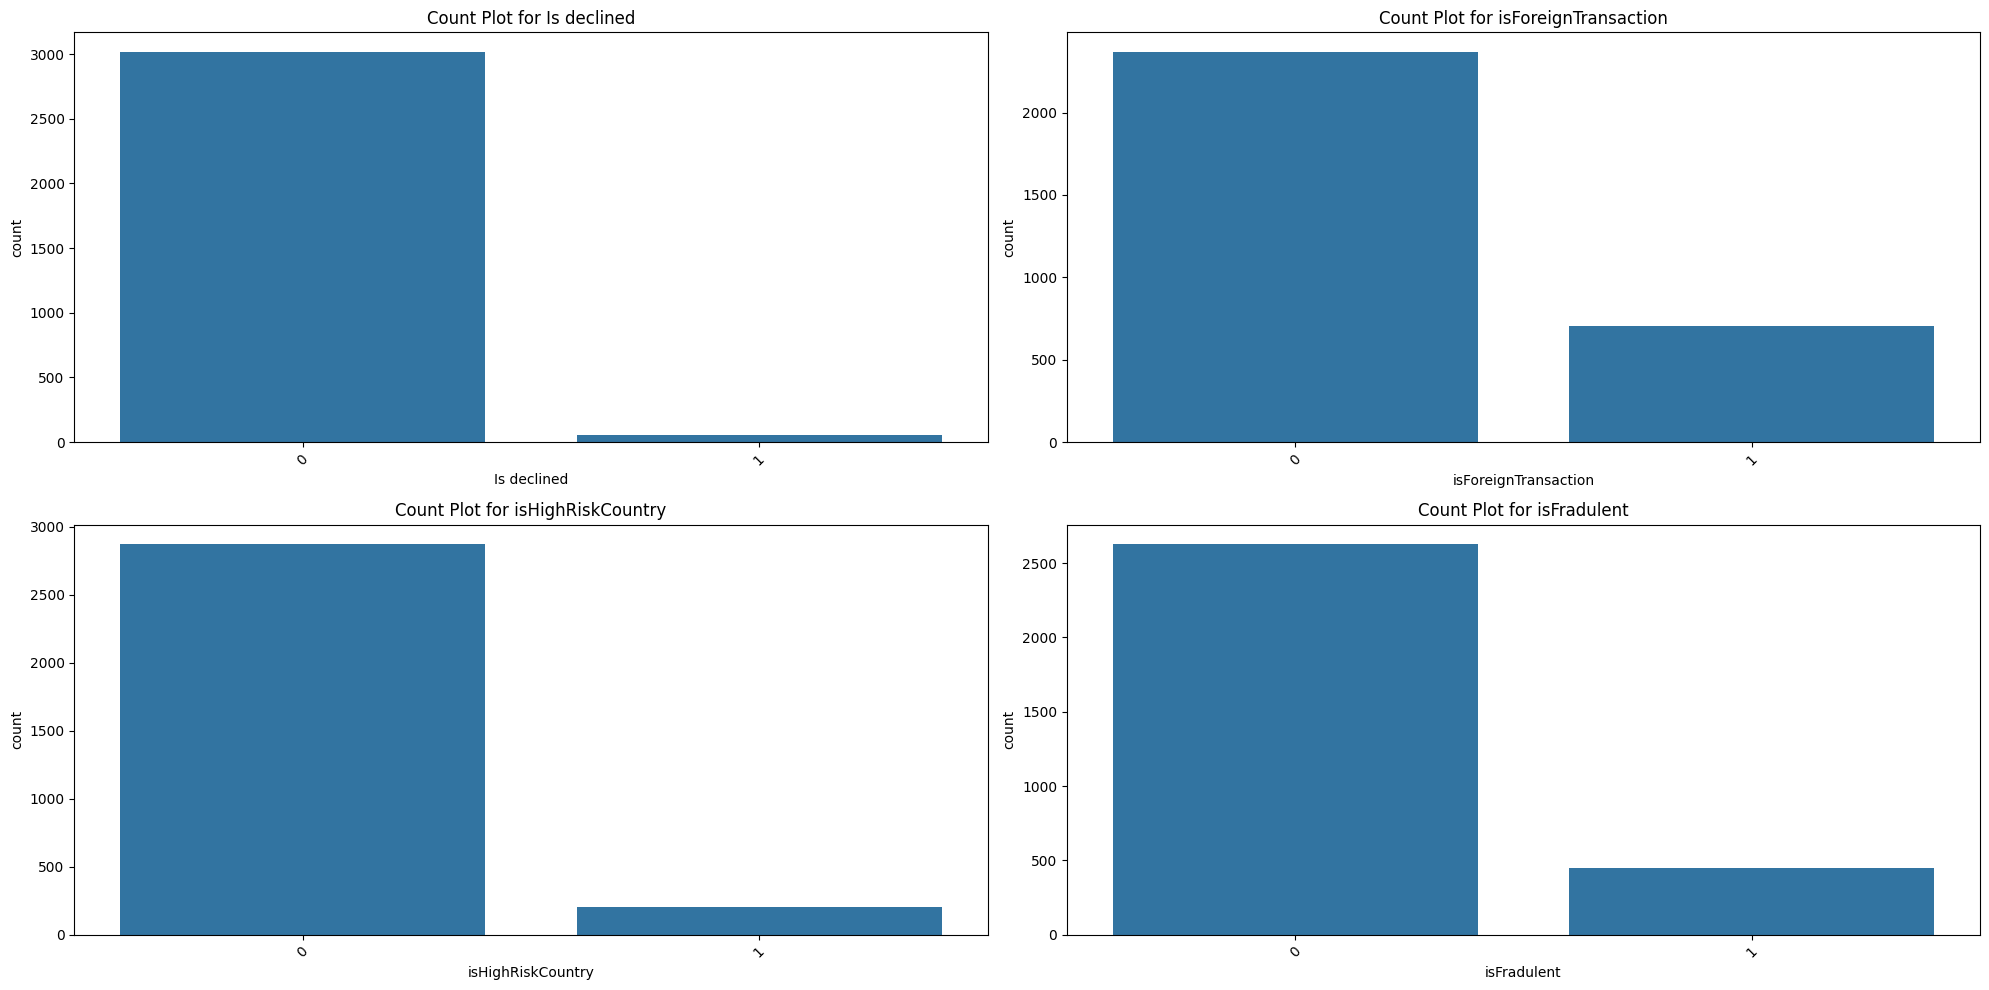

In [14]:
categorical_columns = ['Is declined', 'isForeignTransaction', 'isHighRiskCountry', 'isFradulent']

# Set up the matplotlib figure
plt.figure(figsize=(20, 10))

# Generate count plots for each categorical column
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)  # Adjust the subplot grid size if you have more/less categorical columns
    sns.countplot(data=df, x=col)
    plt.title(f'Count Plot for {col}')
    plt.xticks(rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Explanation why we cant remove this "outleirs"

### before removing outliers, we need to understand whther or not it is reasonible' lets again look at our data

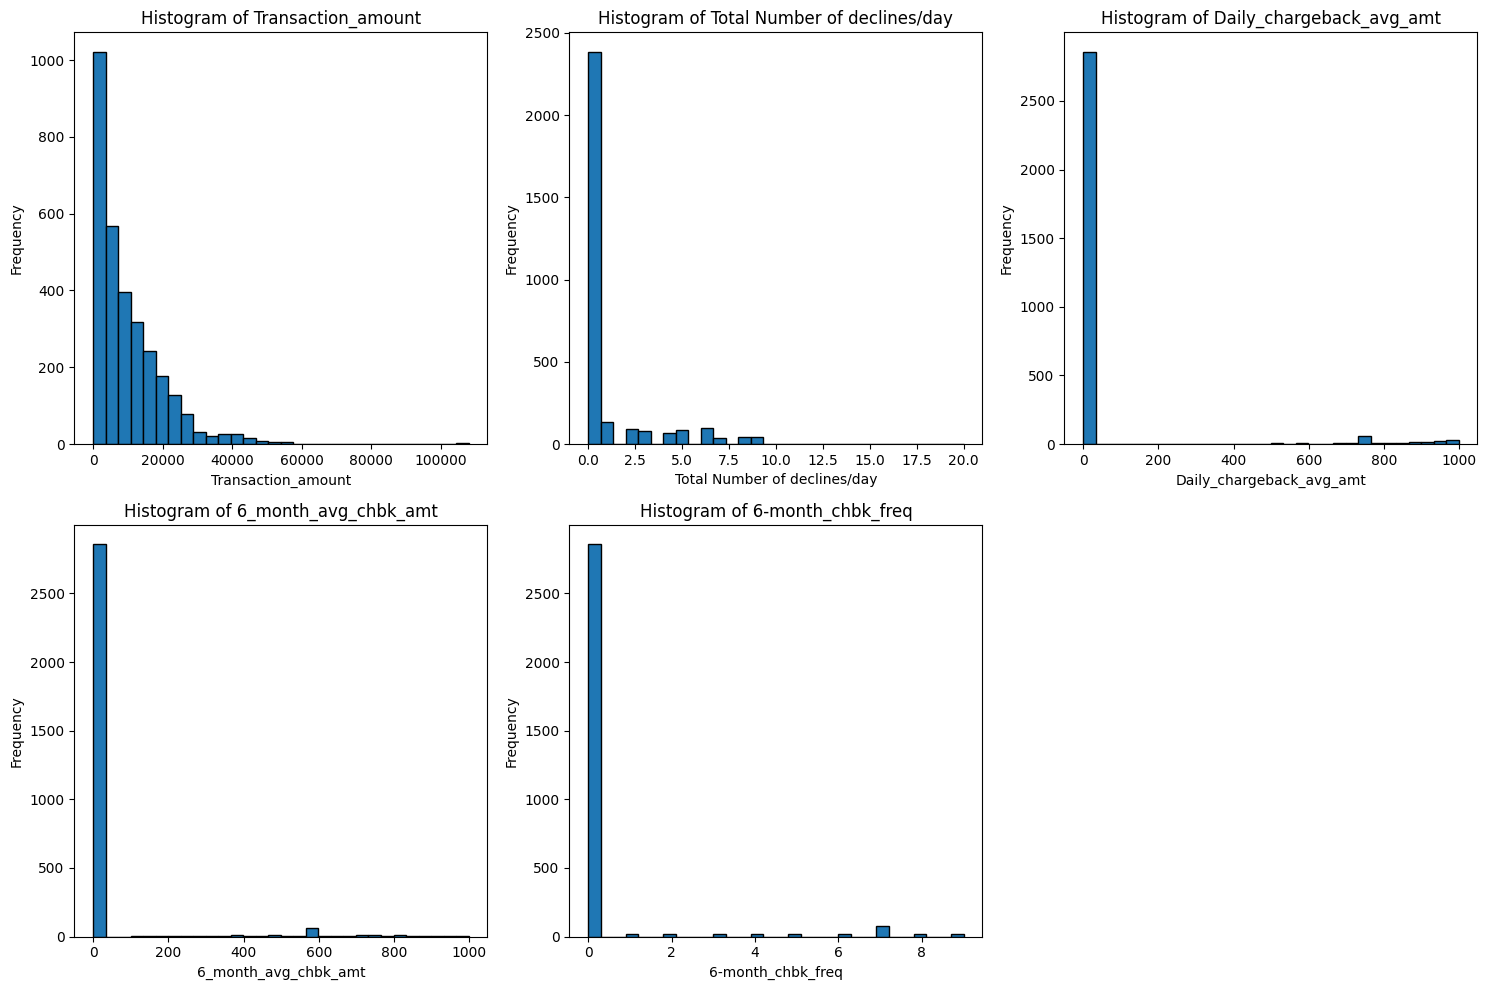

In [15]:
numerical_columns = [
    'Transaction_amount',
    'Total Number of declines/day',
    'Daily_chargeback_avg_amt',
    '6_month_avg_chbk_amt',
    '6-month_chbk_freq'
]

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Generate histograms for each numerical column
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  # Adjust the subplot grid size based on the number of columns
    plt.hist(df[col].dropna(), bins=30, edgecolor='k')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

in our dataset, we cant remove the outliers, because it is what we actually care about the most -> the fraud detection.
We want to detect frauds using anomaly points, thus, we wont handle the outliers right now.
Fraud detection is the process of identifying and mitigating fraudulent activities or
attempts within a system or organization.
* Usually fraud involves anomaly thus, our detection will rely on finding outluers

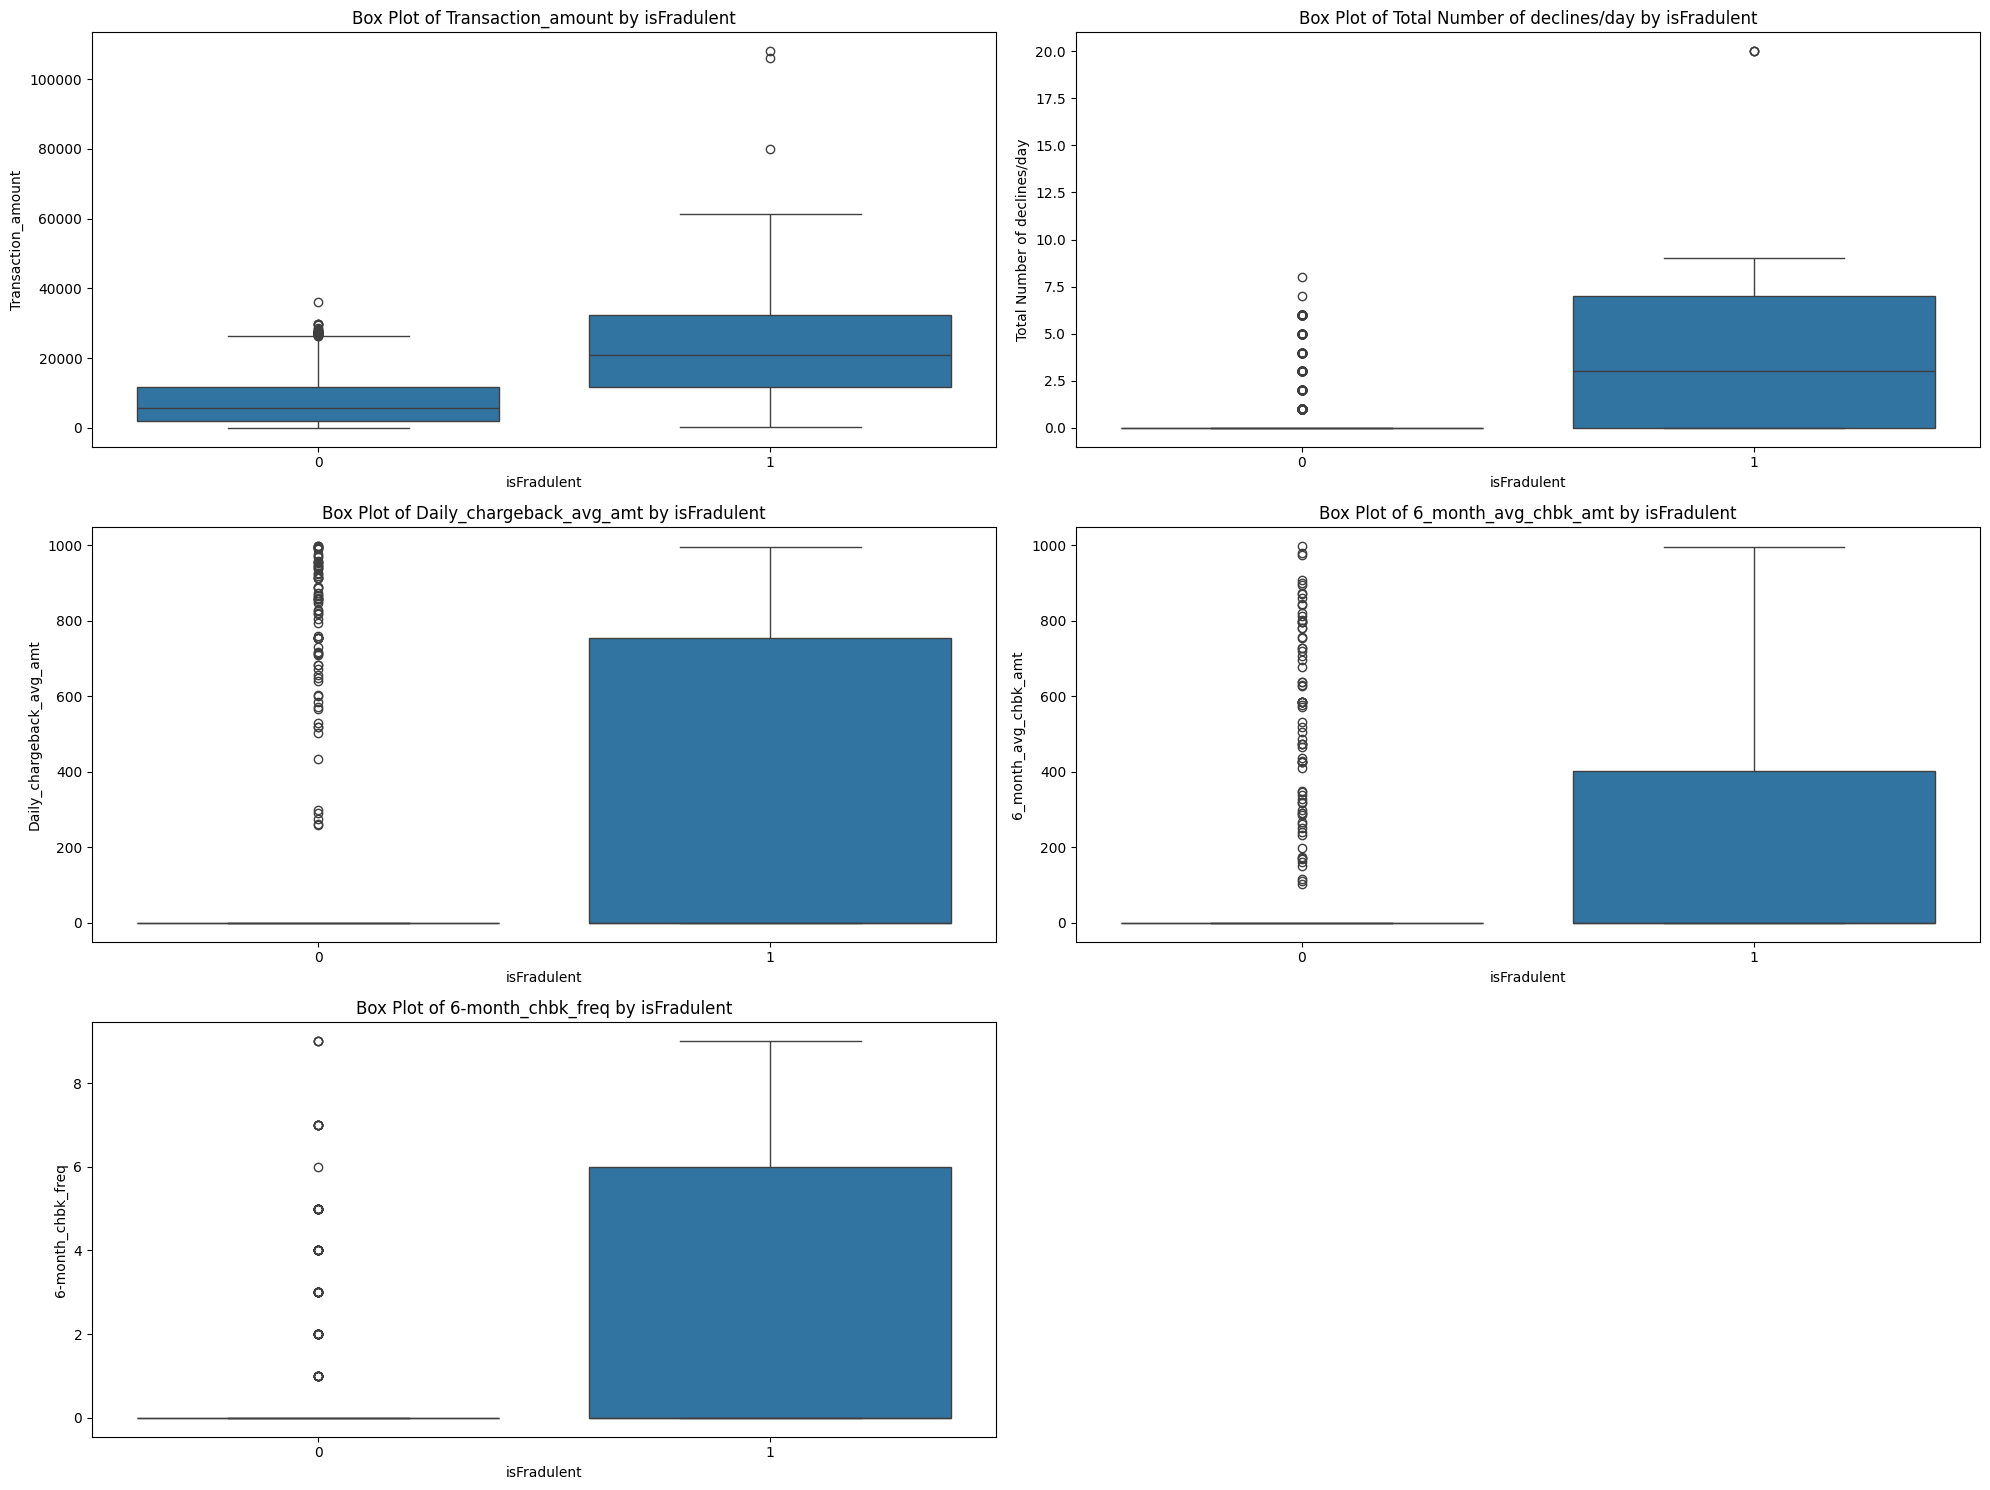

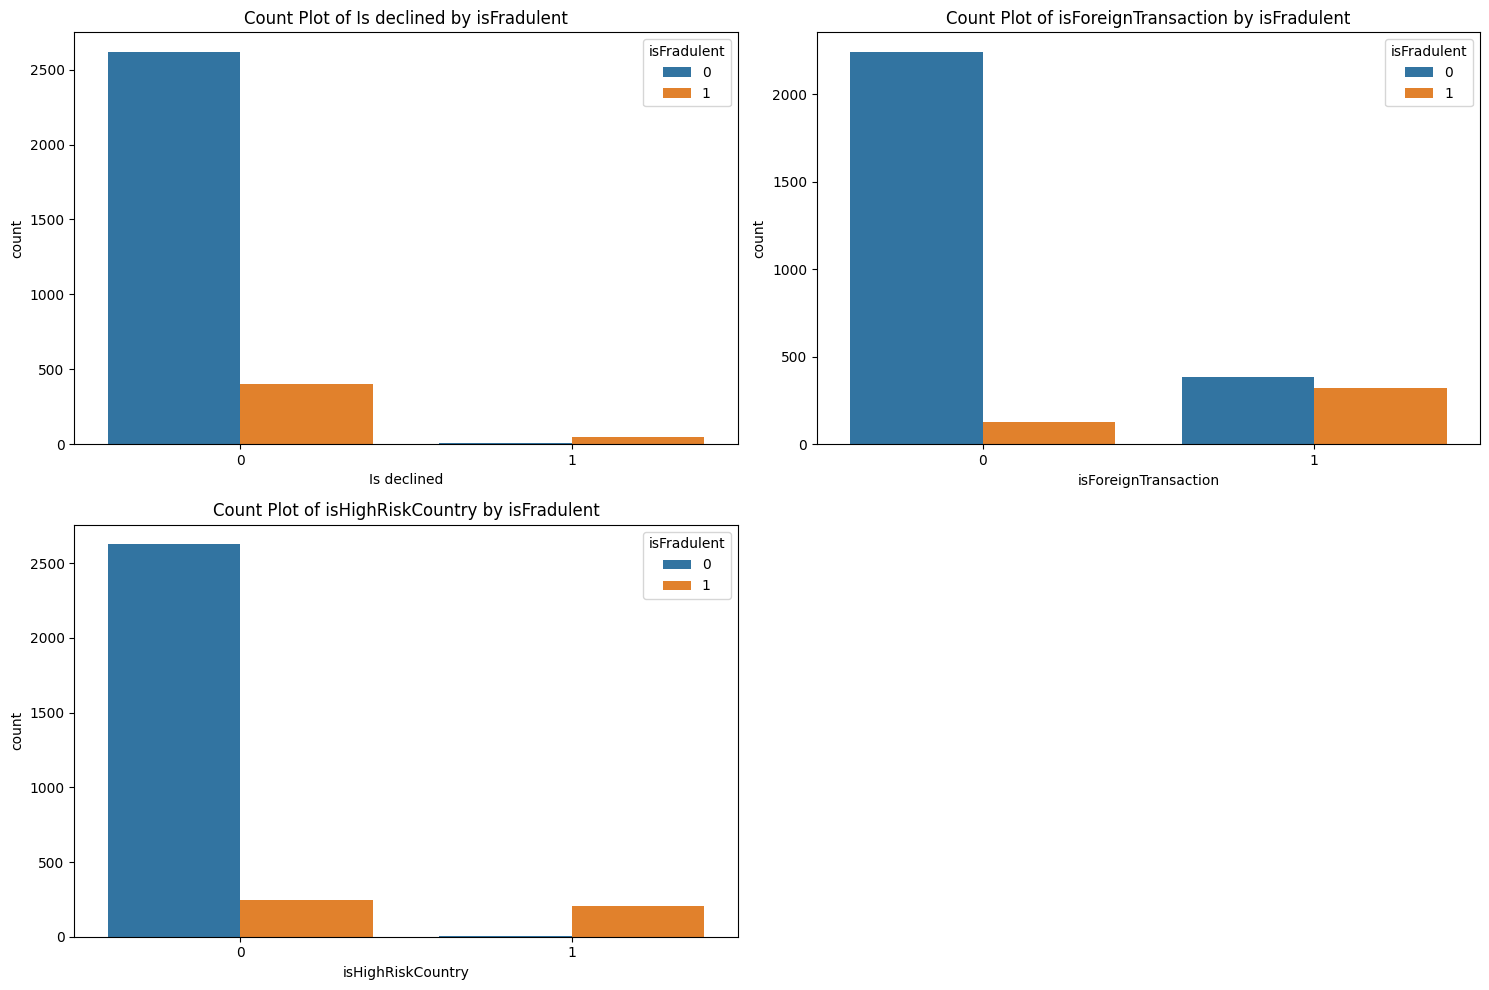

In [16]:
numerical_columns = [
    'Transaction_amount',
    'Total Number of declines/day',
    'Daily_chargeback_avg_amt',
    '6_month_avg_chbk_amt',
    '6-month_chbk_freq'
]

categorical_columns = ['Is declined', 'isForeignTransaction', 'isHighRiskCountry']

# Plot numerical features
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x='isFradulent', y=col)
    plt.title(f'Box Plot of {col} by isFradulent')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Plot categorical features
plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=col, hue='isFradulent')
    plt.title(f'Count Plot of {col} by isFradulent')
    plt.legend(title='isFradulent', loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

1.	Transaction Amount by isFradulent:
* Observations:
	-	Non-fraudulent transactions (0) tend to have lower transaction amounts with a lower range.
	-	Fraudulent transactions (1) tend to have higher transaction amounts with a wider range and more outliers.
	-	There are several high-value outliers in fraudulent transactions.
2. Total Number of Declines/Day by isFradulent:
* Observations:
	-	Non-fraudulent transactions (0) typically have fewer declines per day.
	-	Fraudulent transactions (1) have higher declines per day, suggesting a pattern of frequent declines being associated with fraud.
3. Daily Chargeback Average Amount by isFradulent:
* Observations:
	-	Non-fraudulent transactions (0) have a low average daily chargeback amount, with many values clustering around zero.
	-	Fraudulent transactions (1) have significantly higher average daily chargeback amounts, indicating a strong association with chargebacks.
4. 6-Month Average Chargeback Amount by isFradulent:
* Observations:
	-	Non-fraudulent transactions (0) have lower 6-month average chargeback amounts.
	-	Fraudulent transactions (1) have higher 6-month average chargeback amounts, indicating that fraud is associated with higher chargeback activity over a longer period.
5. 6-Month Chargeback Frequency by isFradulent:
* Observations:
	-	Non-fraudulent transactions (0) have lower chargeback frequencies.
	-	Fraudulent transactions (1) have significantly higher chargeback frequencies, suggesting that fraudulent activity often involves frequent chargebacks.


### Fraudulent Transactions: Generally associated with higher transaction amounts, more declines per day, higher average daily and 6-month chargeback amounts, and higher chargeback frequencies.
* Non-Fraudulent Transactions: Tend to have lower values in these metrics, with fewer declines, lower chargeback amounts, and lower chargeback frequencies.
* These insights can help in identifying patterns and characteristics associated with fraudulent transactions, which can be useful for building models to predict and detect fraud.


## Now we will split the data to 
* Train
* Test
* Validation
#### firstly, we will use stratifeid shuffle and shuffle the data

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

now, as for why we chose to split after performing EDA:

1. Ensuring Data Integrity and Consistency

	•	Data Cleaning: Before splitting the data, you need to handle missing values, remove duplicates, and correct any inconsistencies in the dataset. Performing these steps ensures that the data fed into both the training and testing sets is clean and of high quality.
	•	Uniformity: Data cleaning ensures that both the training and testing sets have the same structure and format, which is essential for building and evaluating the model effectively.

2. Preventing Data Leakage

	•	Data Leakage: If the train/test split is performed before data cleaning, there’s a risk that information from the test set could inadvertently influence the training set during the cleaning process. This can lead to overly optimistic performance estimates and poor generalization to new data.
	•	Isolation: By splitting the data after cleaning, you ensure that the test set remains a true representation of unseen data, preserving its integrity for unbiased model evaluation.

3. Ensuring Comprehensive EDA

	•	Exploratory Data Analysis: EDA involves understanding the data distribution, identifying relationships between variables, and uncovering patterns. Performing EDA on the entire dataset ensures that you have a comprehensive understanding of the data before any modifications.
	•	Informed Cleaning: Insights gained from EDA guide the data cleaning process. For example, you might identify outliers or anomalies that need to be addressed before splitting the data.

4. Maintaining the Distribution of Data

	•	Stratified Splitting: After EDA, you might decide to use stratified sampling to ensure that the train and test sets have the same distribution of key variables (e.g., target classes). This is particularly important for imbalanced datasets.
	•	Balanced Evaluation: Maintaining the distribution ensures that both the training and testing sets are representative of the overall dataset, leading to more reliable model evaluation.

5. Efficient Use of Resources

	•	Resource Allocation: Cleaning and preparing data can be resource-intensive. Performing these tasks once on the entire dataset, rather than separately on training and testing sets, is more efficient.
	•	Avoiding Redundancy: By conducting EDA and cleaning on the entire dataset, you avoid redundant processing and ensure that both sets benefit from the same cleaning procedures.

6. Consistent Feature Engineering

	•	Feature Engineering: EDA often leads to feature engineering decisions, such as creating new variables or transforming existing ones. Performing these steps on the entire dataset ensures consistency in the features used by the model.
	•	Robust Model Development: Consistent features across training and testing sets ensure that the model can leverage the same information during both training and evaluation phases.

Summary

Constructing the train/test split after EDA and data cleaning ensures that the data used for training and testing is of high quality, free from inconsistencies, and reflective of the actual data distribution. This approach minimizes the risk of data leakage, ensures comprehensive analysis and cleaning, and leads to more reliable and unbiased model evaluation.

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# Split the train set into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

### We will use 4 models of unsupervised learning:
1. Isolation forest
2. Neural Networks with LSTM autoencoders
3. Local Outlier Factor
4. Gaussian mixture
   
We want to find the pattern of fraudulent purchases. Every person generally has certain patterns of purchases which they make. If there is an outlier to this pattern the bank needs to detect it in order to analyze it for potential fraud. In those models we will find outliers assuming frauds will be expressed as outliers.

# Metrics

In [19]:
# Create a results dataframe to store and later compare results
results = pd.DataFrame()
resultsCrossVal = pd.DataFrame()
results['Metrics'] = ['True Negatives', 'False Negatives', 'False Positives', 'True Positives', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support']
resultsCrossVal['Metrics'] = ['True Negatives', 'False Negatives', 'False Positives', 'True Positives', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support']

def get_metrics(labels, pred_labels):
    conf_matrix = np.asarray(confusion_matrix(labels, pred_labels))
    metrics = np.concatenate(([accuracy_score(labels, pred_labels)], precision_recall_fscore_support(labels, pred_labels, average='binary')))
    return np.concatenate((conf_matrix.reshape(-1),metrics))

def fit_model(input_data, model_fn, model_args=None, threshold=None, labels=None):
    return model_fn(input_data, model_args, threshold, labels)

def predict_model(input_data, model, predict_fn, threshold=None):
    return predict_fn(input_data, model, threshold)

In [20]:
X = train_df.drop(columns=['isFradulent'])
y = train_df['isFradulent']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Isolation Forest

In [21]:
def fit_isolation_forest(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = IsolationForest()
    else:
        model = IsolationForest(contamination=threshold)
    
    model.fit(input_data)

    return model

def predict_isolation_forest(input_data, model, threshold=None):
    y_pred = model.predict(input_data)
    y_pred = [1 if pred == -1 else 0 for pred in y_pred]

    return y_pred

In [22]:
if_model = fit_model(X_train, fit_isolation_forest, None)

y_pred_test = predict_model(X_test, if_model, predict_isolation_forest)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[320  17]
 [  6  51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       337
           1       0.75      0.89      0.82        57

    accuracy                           0.94       394
   macro avg       0.87      0.92      0.89       394
weighted avg       0.95      0.94      0.94       394



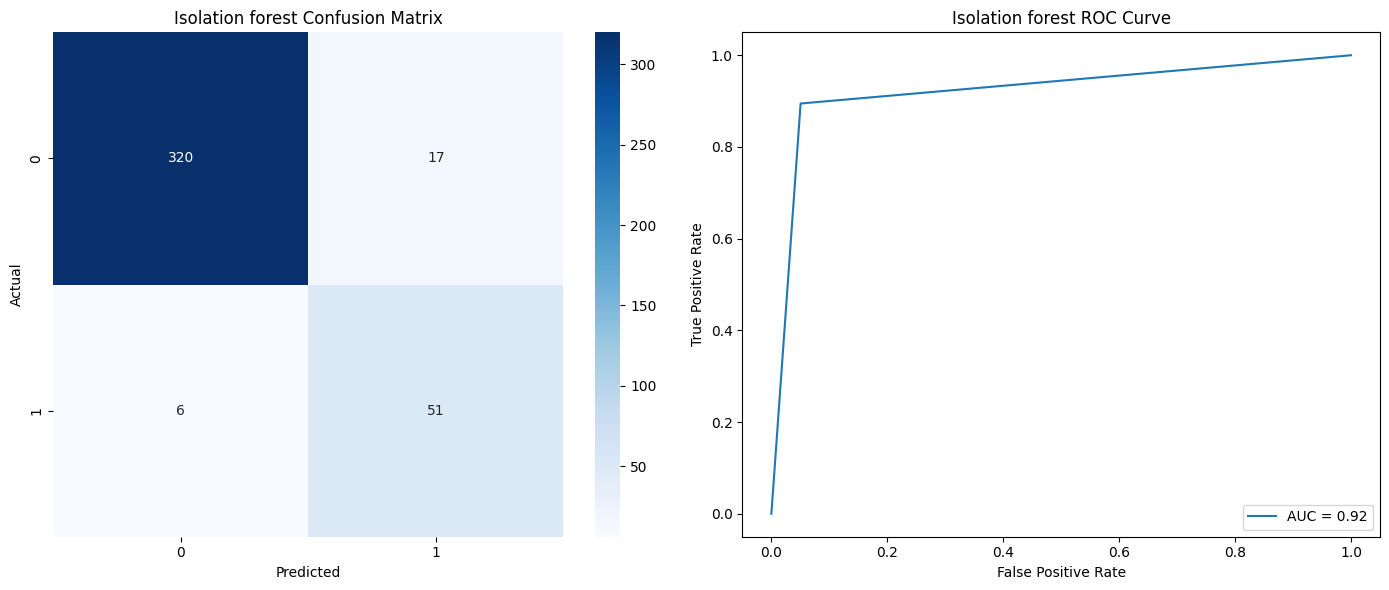

In [23]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
auc = roc_auc_score(y_test,y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Isolation forest Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
ax[1].set_title('Isolation forest ROC Curve')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [24]:
results['Isolation Forest'] = get_metrics(y_test, y_pred_test)

# Cross Validation

In [25]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize Isolation Forest
    model = IsolationForest(random_state=42)
    
    # Fit the model on the training data
    model.fit(X_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Convert predictions from {-1, 1} to {0, 1}
    y_pred = np.where(y_pred == -1, 1, 0)
    
    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Print evaluation metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1:.2f}')

Average Accuracy: 0.95
Average Precision: 0.77
Average Recall: 0.94
Average F1 Score: 0.85


In [26]:
resultsCrossVal['Isolation Forest'] = get_metrics(y_test, y_pred)

# Local Outlier Factor

#### Dataset Distribution (Outlier and Novelty detection)

We have to distribute the datasets in two different ways in order to perform both outlier and novelty detection. 

For **Outlier Detection** dataset we are going to concat train and test set since this methods run predictions over the same data. 

For **Novelty Detection** dataset we need to remove all fraud samples from the training set and put them on the test set.

In [27]:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_test = pd.concat([X_test, y_test], axis=1)

# Outlier-detection Dataset
X_out_train = pd.concat([Xy_train, Xy_test], axis=0)
y_out_train = pd.DataFrame(X_out_train['isFradulent'])
X_out_train.drop('isFradulent', axis='columns', inplace= True)

# Novelty-detection Dataset
X_nov_train = Xy_train[Xy_train['isFradulent'] == 0].copy()
X_nov_train.drop('isFradulent', axis='columns', inplace= True)
X_nov_train_val = Xy_train.drop('isFradulent', axis='columns', inplace= False)
y_nov_train_val = y_train

print('X_train', str(len(X_train)))
print('X_nov_train', str(len(X_nov_train)))
print('X_out_train', str(len(X_out_train)))
print('y_out_train', str(len(y_out_train)))
print('X_test', str(len(X_test)))
print('y_test', str(len(y_test)))

X_train 1575
X_nov_train 1363
X_out_train 1968
y_out_train 1968
X_test 393
y_test 393


### Training

In [28]:
# Calculate outlier_fraction value to be sent as contamination parameter
no_fraud = len(y_out_train[y_out_train['isFradulent'] == 1])
no_valid = len(y_out_train) - no_fraud

outlier_fraction = no_fraud/float(no_valid)

print('X_train len: ',len(X_out_train))
print('y_train len: ',len(y_out_train))
print('total: ',no_fraud+no_valid)
print('no_fraud: ',no_fraud)
print('no_valid: ',no_valid)
print('Outlier Fraction: ',outlier_fraction)

X_train len:  1968
y_train len:  1968
total:  1968
no_fraud:  267
no_valid:  1701
Outlier Fraction:  0.15696649029982362


In [29]:
lof_model = LocalOutlierFactor(n_neighbors = 20,contamination = outlier_fraction, novelty=False)

y_prediction1 = lof_model.fit_predict(X_out_train) # Fitting the model.

y_prediction1[y_prediction1 == 1] = 0 # Valid transactions are labelled as 0.
y_prediction1[y_prediction1 == -1] = 1 # Fraudulent transactions are labelled as 1.

print('CLASSIFICATION RESULTS')
print(classification_report(y_out_train,y_prediction1))

CLASSIFICATION RESULTS
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1701
           1       0.39      0.45      0.42       267

    accuracy                           0.83      1968
   macro avg       0.65      0.67      0.66      1968
weighted avg       0.84      0.83      0.84      1968



# Novelty Detection

In [30]:
def fit_local_outlier_factor(input_data, args, threshold=None, labels=None):
    # Combine input data and labels into a single DataFrame
    Xy_input = pd.concat([input_data, labels], axis=1)

    # Select rows where 'isFradulent' is 0 (non-fraudulent transactions)
    X_no_fraud = Xy_input[Xy_input['isFradulent'] == 0].copy()

    # Drop the 'isFradulent' column as it is not needed for the model
    X_no_fraud.drop('isFradulent', axis='columns', inplace=True)

    # Calculate the outlier fraction if threshold is not provided
    if threshold is None:
        no_fraud = len(labels[labels == 1])
        no_valid = len(labels) - no_fraud
        outlier_fraction = no_fraud / float(no_valid)
        model = LocalOutlierFactor(n_neighbors=args[0], contamination=outlier_fraction, novelty=True)
    else:
        model = LocalOutlierFactor(n_neighbors=args[0], contamination=threshold, novelty=True)
    
    # Fit the model on the non-fraudulent data
    model.fit(X_no_fraud)

    return model

def predict_local_outlier_factor(input_data, model, threshold=None):
    y_prediction = model.predict(input_data)
    y_prediction[y_prediction == 1] = 0  # Valid transactions are labelled as 0.
    y_prediction[y_prediction == -1] = 1  # Fraudulent transactions are labelled as 1.

    return y_prediction

In [31]:
def fit_model(input_data, model_fn, model_args=None, threshold=None, labels=None):
    return model_fn(input_data, model_args, threshold, labels)

def predict_model(input_data, model, predict_fn):
    return predict_fn(input_data, model)

In [32]:
lof_model = fit_local_outlier_factor(X_train, [20], labels=y_train)
y_pred_test = predict_local_outlier_factor(X_test, lof_model)

print('CONFUSION MATRIX:\n', confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[286  52]
 [ 16  39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.89       338
           1       0.43      0.71      0.53        55

    accuracy                           0.83       393
   macro avg       0.69      0.78      0.71       393
weighted avg       0.87      0.83      0.84       393



**Note:** We will only use the Novelty Detection results, since we want to compare results over the same test data and we only can run prediction with outlier detection over the training data.

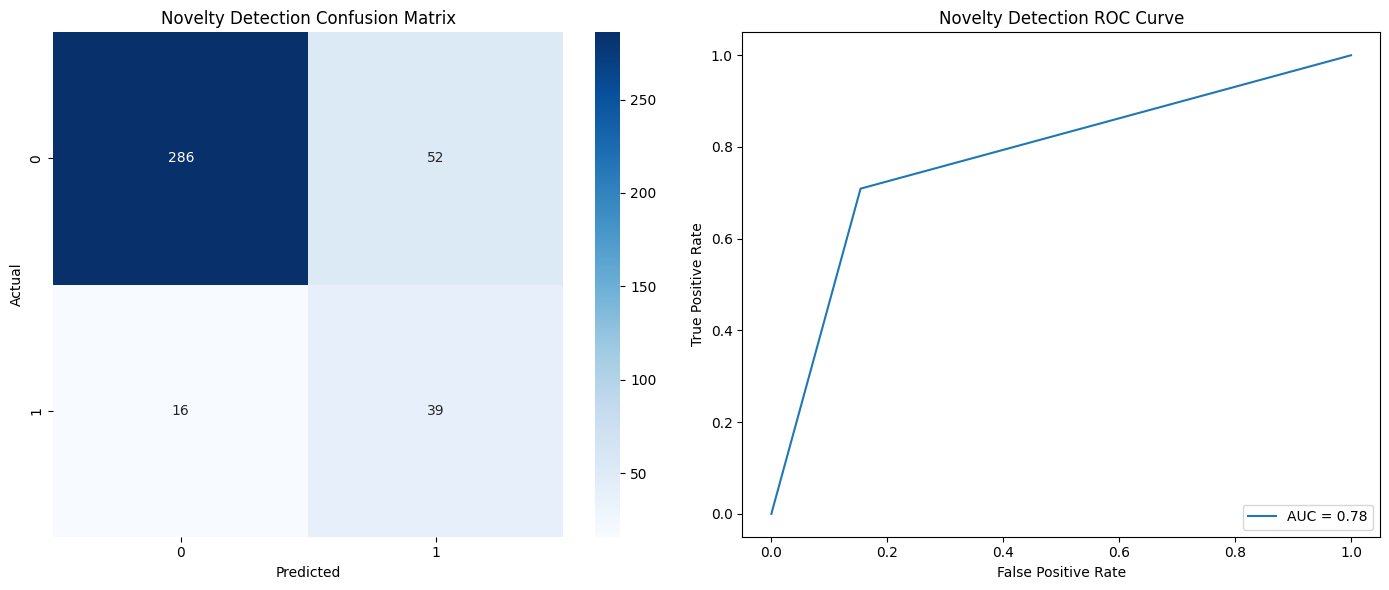

In [33]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
auc = roc_auc_score(y_test,y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Novelty Detection Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
ax[1].set_title('Novelty Detection ROC Curve')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [34]:
results['LOF Novelty Detection'] = get_metrics(y_test,y_pred_test)

## Cross validation

In [35]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize Local Outlier Factor with novelty=True for novelty detection
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
    
    # Fit the model on the training data
    lof.fit(X_train)
    
    # Predict on the test data
    y_pred = lof.predict(X_test)
    
    # Convert predictions from {-1, 1} to {0, 1}
    y_pred = np.where(y_pred == -1, 1, 0)
    
    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Print evaluation metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1:.2f}')

Average Accuracy: 0.85
Average Precision: 0.44
Average Recall: 0.34
Average F1 Score: 0.38


In [36]:
resultsCrossVal['LOF (Novelty Detection)'] = get_metrics(y_test, y_pred)

# Gaussian Mixture

In [37]:
def fit_gaussian_mixture(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = GaussianMixture(n_components=2)
    else:
        model = GaussianMixture(n_components=2, reg_covar=threshold)
    
    model.fit(input_data)

    return model

def predict_gaussian_mixture(input_data, model, threshold=None):
    return model.predict(input_data)

In [38]:
gm_model = fit_model(X_train, fit_gaussian_mixture, None)

y_pred_test = predict_model(X_test, gm_model, predict_gaussian_mixture)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[332   6]
 [  9  46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       338
           1       0.88      0.84      0.86        55

    accuracy                           0.96       393
   macro avg       0.93      0.91      0.92       393
weighted avg       0.96      0.96      0.96       393



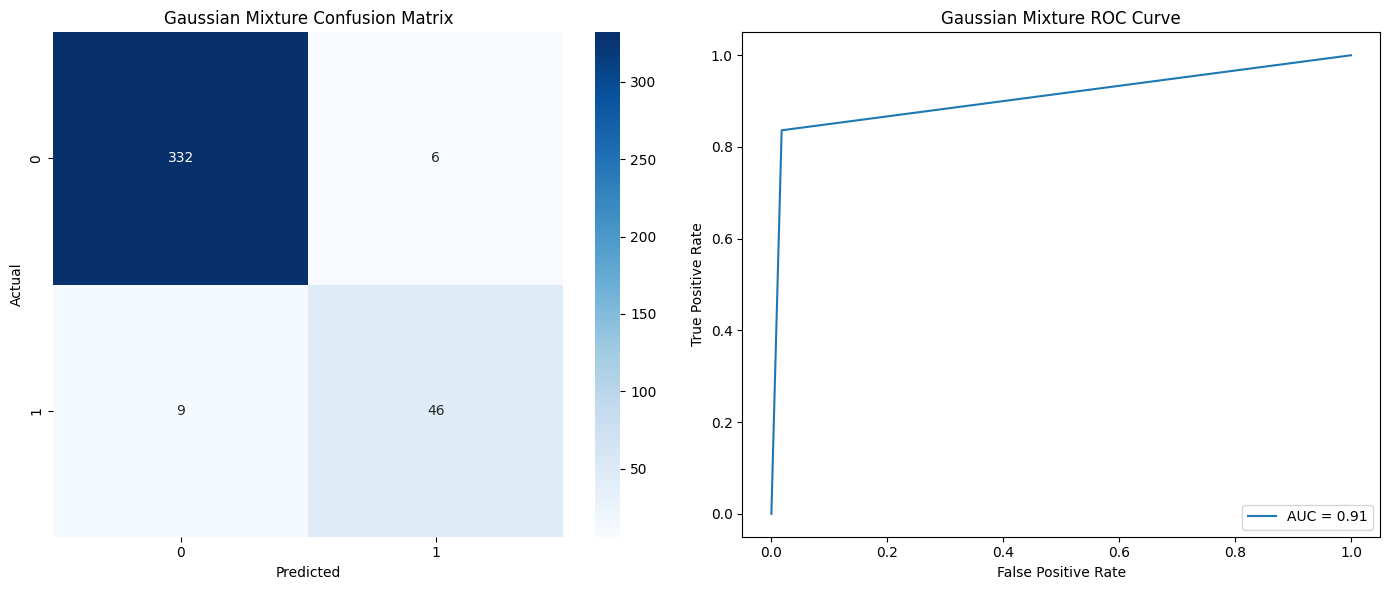

In [39]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
auc = roc_auc_score(y_test,y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Gaussian Mixture Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
ax[1].set_title('Gaussian Mixture ROC Curve')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# For Gaussian mixture we are interested in running time, and converges time, lets check

In [40]:
# Start the timer
start_time = time.time()

# Train the model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_train)

# End the timer and calculate elapsed time
end_time = time.time()
training_time = end_time - start_time

print(f"Gaussian Mixture Model Training Time: {training_time} seconds")
print(f"Gaussian Mixture Model Converged in {gmm.n_iter_} iterations")

Gaussian Mixture Model Training Time: 0.048734426498413086 seconds
Gaussian Mixture Model Converged in 7 iterations


In [41]:
results['Gaussian Mixture'] = get_metrics(y_test, y_pred_test)

In [42]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2, random_state=42)
    
    # Fit the model on the training data
    gmm.fit(X_train)
    
    # Predict on the test data
    y_pred = gmm.predict(X_test)
    
    # The GMM labels clusters; we need to convert to anomaly detection
    # Assign the smaller cluster to be anomalies
    labels = gmm.predict(X_train)
    cluster_sizes = np.bincount(labels)
    anomaly_cluster = np.argmin(cluster_sizes)
    y_pred = np.where(gmm.predict(X_test) == anomaly_cluster, 1, 0)
    
    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Print evaluation metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1:.2f}')

Average Accuracy: 0.94
Average Precision: 0.82
Average Recall: 0.71
Average F1 Score: 0.76


In [43]:
resultsCrossVal['Gaussian Mixture Model'] = get_metrics(y_test, y_pred)

## Autoencoders

In [44]:
import numpy as np
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler

def create_autoencoder(input_dim):
    encoding_dim = 32  # Adjust this based on your data complexity
    
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation='relu')(inputs)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)
    
    # Autoencoder
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder, encoder

def autoencoder_fit(input_data, model_args, threshold=None, labels=None):
    X_train, y_train = input_data
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Create and fit the autoencoder
    autoencoder, encoder = create_autoencoder(X_train.shape[1])
    
    # Train only on normal samples
    normal_samples = X_train_scaled[y_train == 0]
    
    autoencoder.fit(normal_samples, normal_samples,
                    epochs=50,  # Adjust as needed
                    batch_size=32,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=0)
    
    return (autoencoder, encoder), scaler

def autoencoder_predict(input_data, model, threshold=None):
    (autoencoder, encoder), scaler = model
    X_scaled = scaler.transform(input_data)
    
    # Compute reconstruction error
    reconstructed = autoencoder.predict(X_scaled)
    mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)
    
    # If threshold is not provided, use the 95th percentile of the MSE as the threshold
    if threshold is None:
        threshold = np.percentile(mse, 95)
    
    # Classify as anomaly if reconstruction error is above the threshold
    y_pred = (mse > threshold).astype(int)
    
    return y_pred

# Add Autoencoder
autoencoder_model, autoencoder_scaler = autoencoder_fit((X_train, y_train), None)
autoencoder_predictions = autoencoder_predict(X_test, (autoencoder_model, autoencoder_scaler))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [45]:
# Calculate and store metrics for Autoencoder
autoencoder_metrics = get_metrics(y_test, autoencoder_predictions)
results['Autoencoder'] = autoencoder_metrics

# Autoencoders Results
print('CONFUSION MATRIX:\n', confusion_matrix(y_test, autoencoder_predictions))
print("Classification Report:\n", classification_report(y_test, autoencoder_predictions))

CONFUSION MATRIX:
 [[335   3]
 [ 38  17]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       338
           1       0.85      0.31      0.45        55

    accuracy                           0.90       393
   macro avg       0.87      0.65      0.70       393
weighted avg       0.89      0.90      0.87       393



In [46]:
results['Autoencoder'] = get_metrics(y_test, autoencoder_predictions)

In [47]:
# Cross-Vaildation for Autoencoders

# Parameters for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the autoencoder model on the training data
    autoencoder_model, autoencoder_scaler = autoencoder_fit((X_train, y_train), None)
    
    # Predict on the test data
    y_pred = autoencoder_predict(X_test, (autoencoder_model, autoencoder_scaler))
    
    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Print evaluation metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1:.2f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Average Accuracy: 0.90
Average Precision: 0.82
Average Recall: 0.31
Average F1 Score: 0.45


In [48]:
resultsCrossVal['Autoencoders'] = get_metrics(y_test, y_pred)

# KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

def knn_fit(input_data, model_args, threshold=None, labels=None):
    X_train, y_train = input_data
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Create and fit the KNN model
    n_neighbors = model_args.get('n_neighbors', 5)
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_scaled, y_train)
    
    return knn, scaler

def knn_predict(input_data, model, threshold=None):
    knn, scaler = model
    X_scaled = scaler.transform(input_data)
    
    # Get probability predictions
    y_pred_proba = knn.predict_proba(X_scaled)[:, 1]
    
    # Apply threshold if provided, otherwise use default 0.5
    if threshold is not None:
        y_pred = (y_pred_proba >= threshold).astype(int)
    else:
        y_pred = (y_pred_proba >= 0.5).astype(int)
    
    return y_pred

# Add KNN
knn_model, knn_scaler = fit_model((X_train, y_train), knn_fit, model_args={'n_neighbors': 5})
knn_predictions = predict_model(X_test, (knn_model, knn_scaler), knn_predict)

In [50]:
# Calculate and store metrics for KNN
knn_metrics = get_metrics(y_test, knn_predictions)
results['KNN'] = knn_metrics

In [51]:
# Print KNN results
print('CONFUSION MATRIX:\n', confusion_matrix(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))

CONFUSION MATRIX:
 [[337   1]
 [  5  50]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       338
           1       0.98      0.91      0.94        55

    accuracy                           0.98       393
   macro avg       0.98      0.95      0.97       393
weighted avg       0.98      0.98      0.98       393



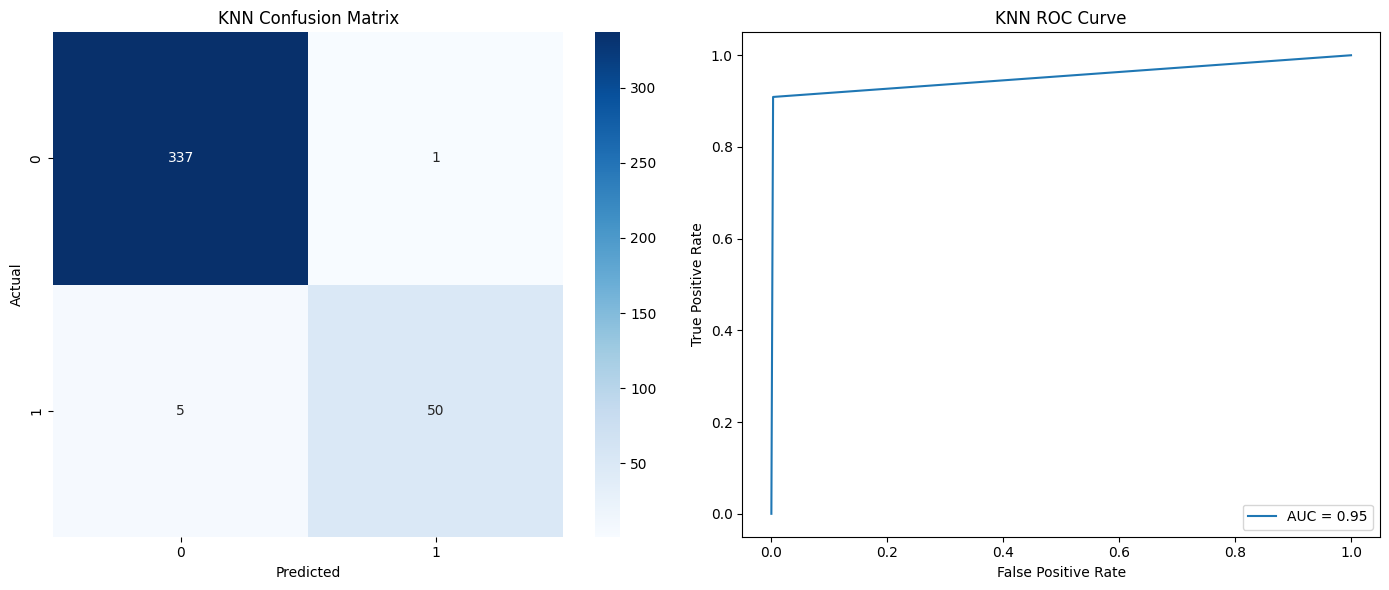

In [52]:
cm = confusion_matrix(y_test, knn_predictions)
fpr, tpr, _ = roc_curve(y_test, knn_predictions)
auc = roc_auc_score(y_test, knn_predictions)

# Plot Confusion Matrix and ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('KNN Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
ax[1].set_title('KNN ROC Curve')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [53]:
# Calculate and store metrics for KNN
knn_metrics = get_metrics(y_test, knn_predictions)
results['KNN'] = knn_metrics

# Cross Validation

In [54]:
def cross_val_knn(X, y, model_args, cv=5):
    n_neighbors = model_args.get('n_neighbors', 5)
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Standardize the features within cross-validation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform cross-validation
    scores = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy')
    
    return scores

In [55]:
model_args = {'n_neighbors': 5}
cv_scores = cross_val_knn(X_train, y_train, model_args, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Fit the model on the entire training set
knn_model, knn_scaler = knn_fit((X_train, y_train), model_args)
knn_predictions = knn_predict(X_test, (knn_model, knn_scaler))


# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Print evaluation metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1:.2f}')

Cross-validation scores: [0.98730159 0.98412698 0.97777778 0.98095238 0.98095238]
Mean cross-validation score: 0.9822222222222223
Average Accuracy: 0.90
Average Precision: 0.82
Average Recall: 0.31
Average F1 Score: 0.45


In [56]:
resultsCrossVal['Knn'] = get_metrics(y_test, knn_predictions)

# RESULTS

# Training Results

In [57]:
results

,Metrics,Isolation Forest,LOF Novelty Detection,Gaussian Mixture,Autoencoder,KNN
0,True Negatives,320,286,332,335,337
1,False Negatives,17,52,6,3,1
2,False Positives,6,16,9,38,5
3,True Positives,51,39,46,17,50
4,Accuracy,0.941624,0.826972,0.961832,0.895674,0.984733
5,Precision,0.75,0.428571,0.884615,0.85,0.980392
6,Recall,0.894737,0.709091,0.836364,0.309091,0.909091
7,F1-Score,0.816,0.534247,0.859813,0.453333,0.943396
8,Support,None,None,None,None,None


# Lets check if our best UNSUPERVIESED model(Isolation Forest) is overfitting:

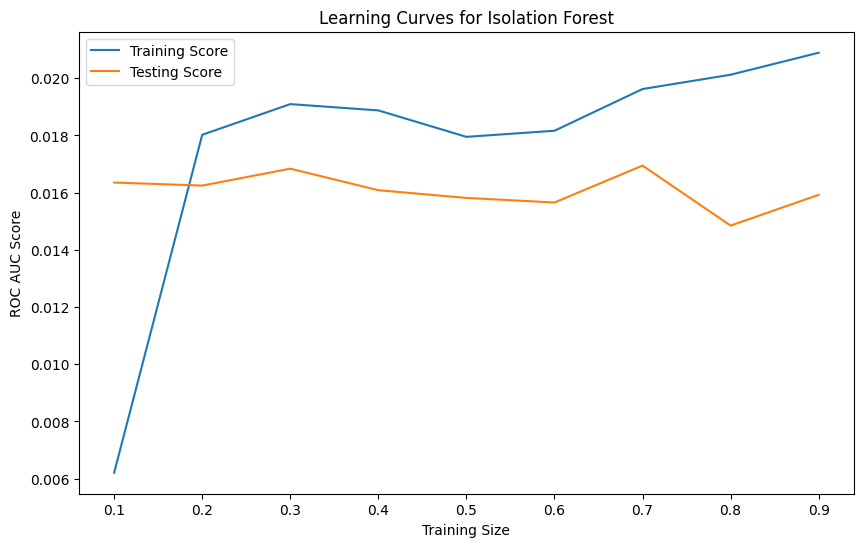

In [59]:
# Train Isolation Forest on different subsets of the training data
train_sizes = np.linspace(0.1, 0.9, 9)  # Adjusted to avoid 1.0
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_subset)
    
    y_train_pred = iso_forest.decision_function(X_train_subset)
    y_test_pred = iso_forest.decision_function(X_test)
    
    train_scores.append(roc_auc_score(y_train_subset, y_train_pred))
    test_scores.append(roc_auc_score(y_test, y_test_pred))

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, label='Training Score')
plt.plot(train_sizes, test_scores, label='Testing Score')
plt.xlabel('Training Size')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curves for Isolation Forest')
plt.legend()
plt.show()

* The training score (blue line) remains relatively low and stable across different training sizes, which suggests that the model is not overfitting to the training data.
* The testing score (orange line) is also relatively low but shows some variability, which indicates that the model’s performance on the test data is not highly sensitive to the training size.

Given that both the training and testing scores are low and close to each other, it suggests that the model might be underfitting rather than overfitting.

In [60]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'contamination': [0.05, 0.1, 0.2],
    'max_features': [0.5, 0.7, 1.0]
}

# Initialize the Isolation Forest
iso_forest_tune = IsolationForest(random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=iso_forest_tune, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred_tune = best_model.decision_function(X_test)
test_score_tune = roc_auc_score(y_test, y_test_pred_tune)

best_params, best_score, test_score_tune

({'contamination': 0.05,
  'max_features': 0.5,
  'max_samples': 0.5,
  'n_estimators': 50},
 0.03482101024103947,
 0.023076923076923078)

In [61]:
# Ensure the best parameters are defined correctly
best_params = {
    'n_estimators': 100,  # Example value
    'max_samples': 0.7,
    'contamination': 0.1,
    'max_features': 0.7
}

# Initialize the Isolation Forest with the best parameters
best_isolation_forest = IsolationForest(**best_params, random_state=42)

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the best Isolation Forest model
    best_isolation_forest.fit(X_train)
    
    # Predict on the test data
    y_pred = best_isolation_forest.predict(X_test)
    
    # Convert predictions from {-1, 1} to {0, 1}
    y_pred = np.where(y_pred == -1, 1, 0)
    
    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)
    
    print(f'Fold {i+1}: Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}')

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Print evaluation metrics
print(f'Tuned Average Accuracy: {average_accuracy:.2f}')
print(f'Tuned Average Precision: {average_precision:.2f}')
print(f'Tuned Average Recall: {average_recall:.2f}')
print(f'Tuned Average F1 Score: {average_f1:.2f}')

# Print best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(best_params)

Fold 1: Accuracy: 0.91, Precision: 0.73, Recall: 0.58, F1 Score: 0.65
Fold 2: Accuracy: 0.93, Precision: 0.83, Recall: 0.59, F1 Score: 0.69
Fold 3: Accuracy: 0.94, Precision: 0.84, Recall: 0.68, F1 Score: 0.75
Fold 4: Accuracy: 0.91, Precision: 0.69, Recall: 0.46, F1 Score: 0.55
Fold 5: Accuracy: 0.94, Precision: 0.87, Recall: 0.71, F1 Score: 0.78
Tuned Average Accuracy: 0.93
Tuned Average Precision: 0.79
Tuned Average Recall: 0.60
Tuned Average F1 Score: 0.68
Best parameters found by GridSearchCV:
{'n_estimators': 100, 'max_samples': 0.7, 'contamination': 0.1, 'max_features': 0.7}


still, the base parametres perform better, so we'll stay with them.

## We want now to check running time of our model:

In [62]:
# Measure the training time
start_time = time.time()
if_model.fit(X_train)
training_time = time.time() - start_time

# Measure the prediction time
start_time = time.time()
predictions = if_model.predict(X_test)
prediction_time = time.time() - start_time

# Print the results
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")

Training Time: 0.2027 seconds
Prediction Time: 0.0217 seconds


# Now we want to do the same with KNN our supervised best model

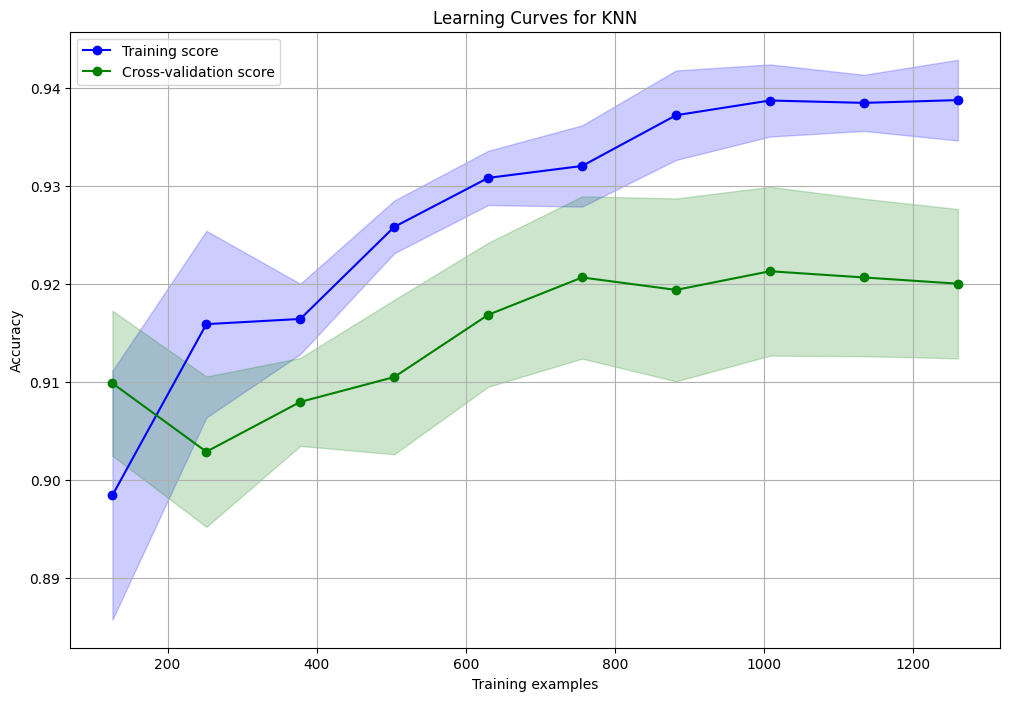

In [63]:
knn = KNeighborsClassifier()
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green', marker='o')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.2)
plt.title('Learning Curves for KNN')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

* Training Score: The training accuracy is consistently high, indicating that the model fits the training data well.
* Cross-Validation Score: The cross-validation accuracy is lower than the training accuracy and shows more variability.

The gap between the training and cross-validation scores suggests that the model performs significantly better on the training data than on unseen data, a classic sign of overfitting.


## Choosing the Optimal Number of Neighbors (k)

Selecting the appropriate number of neighbors (k) is crucial for the KNN algorithm. Too small a value of k can lead to overfitting, while too large a value can result in underfitting. Cross-validation is commonly used to find the optimal value of k.

In [64]:
# Set a random seed
seed_value = 42
np.random.seed(seed_value)

# Load and split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=2, random_state=seed_value)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# KNN Classifier
knn = KNeighborsClassifier()

# Hyperparameter tuning (e.g., GridSearchCV)
param_grid = {'n_neighbors': np.arange(1, 10)}
grid = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_pca, y_train)

# Use the best model
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test_pca)

In [65]:
# Set a random seed
seed_value = 42
np.random.seed(seed_value)

# Define the cross-validation strategy with a fixed random state
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)

# Define the range of k values to test
param_grid = {'n_neighbors': range(1, 31)}

# Use GridSearchCV to find the optimal k with the fixed random state
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Optimal k
best_k = grid_search.best_params_['n_neighbors']
print(f"Optimal number of neighbors: {best_k}")

# Train the KNN model with the optimal k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

Optimal number of neighbors: 1


KNeighborsClassifier(n_neighbors=1)

## Feature Scaling

Feature scaling (standardization or normalization) ensures that all features contribute equally to the distance calculations in KNN. This can prevent certain features from disproportionately influencing the model, thereby reducing overfitting.
* KNN relies on distance metrics (like Euclidean distance) to determine the nearest neighbors. If the features are on different scales (e.g., one feature ranges from 0 to 1 while another ranges from 0 to 1000), the feature with the larger range will dominate the distance calculation.
* Role in KNN: Feature scaling (e.g., standardization using StandardScaler) ensures that each feature contributes equally to the distance calculations. This can be considered analogous to a regularization technique because it helps prevent any single feature from disproportionately influencing the model, which could lead to overfitting or poor generalization.

In [66]:
# Set a random seed
seed_value = 42
np.random.seed(seed_value)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNN model with scaled features
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1)

## PCA
PCA is a dimensionality reduction technique that transforms the data into a new set of features (principal components), which are uncorrelated and capture the most variance in the data. Reducing the number of features (dimensionality) helps in reducing the complexity of the model.
* Role in KNN: By reducing the dimensionality of the data, PCA can improve the performance of KNN by:
* Reducing noise and irrelevant features, which can help in generalization.
* Lowering computational costs, especially with high-dimensional data.
* Reducing the risk of overfitting by simplifying the model.
* This is similar to regularization in that it helps control the complexity of the model, though it does so by reducing the number of features rather than penalizing large coefficients.


In [67]:
# Set a random seed
seed_value = 42
np.random.seed(seed_value)

# Apply PCA to reduce dimensionality with a fixed random state
pca = PCA(n_components=5, random_state=seed_value)  # Choose the number of components based on explained variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train the KNN model with reduced dimensionality
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=1)

* Choosing the Optimal Number of Neighbors (k): Uses cross-validation to select the k value that balances bias and variance.
* Feature Scaling: Ensures that all features contribute equally to the distance metric used by KNN.
* Dimensionality Reduction: Simplifies the model by reducing the number of features, helping to prevent overfitting.

we want to evaluate the best regularization techniqe:

In [68]:
# Set a random seed
seed_value = 42
np.random.seed(seed_value)

# Baseline Model (No Scaling or PCA)
knn_baseline = KNeighborsClassifier(n_neighbors=best_k)
baseline_scores = cross_val_score(knn_baseline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Baseline Model Accuracy: {np.mean(baseline_scores)}")

# Feature Scaling Only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_scaled = KNeighborsClassifier(n_neighbors=best_k)
scaled_scores = cross_val_score(knn_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Scaled Model Accuracy: {np.mean(scaled_scores)}")

# PCA Only (without scaling, which is uncommon but possible)
pca = PCA(n_components=5, random_state=seed_value)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn_pca = KNeighborsClassifier(n_neighbors=best_k)
pca_scores = cross_val_score(knn_pca, X_train_pca, y_train, cv=5, scoring='accuracy')
print(f"PCA Model Accuracy: {np.mean(pca_scores)}")

# Feature Scaling + PCA
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

knn_scaled_pca = KNeighborsClassifier(n_neighbors=best_k)
scaled_pca_scores = cross_val_score(knn_scaled_pca, X_train_scaled_pca, y_train, cv=5, scoring='accuracy')
print(f"Scaled + PCA Model Accuracy: {np.mean(scaled_pca_scores)}")

Baseline Model Accuracy: 0.9294712364776059
Scaled Model Accuracy: 0.982208067940552
PCA Model Accuracy: 0.9294712364776059
Scaled + PCA Model Accuracy: 0.9650551005965019


# In our case feature scaling is the best 'Regularization' techniqe
We'll apply it:

In [69]:
# Apply Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNN model with the scaled data
knn = KNeighborsClassifier(n_neighbors=best_k)  # best_k from your previous grid search
knn.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[329   8]
 [  6  51]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       337
           1       0.86      0.89      0.88        57

    accuracy                           0.96       394
   macro avg       0.92      0.94      0.93       394
weighted avg       0.97      0.96      0.96       394



## Also here, We want now to check running time of our model:

In [70]:
# Start the timer
start_time = time.time()

# Train the model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# End the timer and calculate elapsed time
end_time = time.time()
training_time = end_time - start_time

print(f"KNN Training Time: {training_time} seconds")

KNN Training Time: 0.00894927978515625 seconds


we see that the hyperparameter tunning does not gives us an imporvment, this can accure because of several reasons,





thus, we'll use some regularization techniqes, cause it might happen due to overfitting

# Lets run our TEST DataSet

In [71]:
X = test_df.drop(columns=['isFradulent'])
y = test_df['isFradulent']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Isolation forest

In [72]:
def fit_isolation_forest(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = IsolationForest()
    else:
        model = IsolationForest(contamination=threshold)
    
    model.fit(input_data)

    return model

def predict_isolation_forest(input_data, model, threshold=None):
    y_pred = model.predict(input_data)
    y_pred = [1 if pred == -1 else 0 for pred in y_pred]

    return y_pred

In [73]:
if_model = fit_model(X_train, fit_isolation_forest, None)

y_pred_test = predict_model(X_test, if_model, predict_isolation_forest)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[99  8]
 [ 1 15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       107
           1       0.65      0.94      0.77        16

    accuracy                           0.93       123
   macro avg       0.82      0.93      0.86       123
weighted avg       0.95      0.93      0.93       123



# KNN

In [74]:
# Assuming X_train, X_test, y_train, y_test are already defined

# Step 1: Scale the Training Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Step 2: Train the KNN model on the scaled training data
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# Step 3: Scale the Test Data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Step 4: Make predictions on the scaled test data
y_pred = knn.predict(X_test_scaled)

# Step 5: Evaluate the model on the test data
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[103   4]
 [  0  16]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       107
           1       0.80      1.00      0.89        16

    accuracy                           0.97       123
   macro avg       0.90      0.98      0.93       123
weighted avg       0.97      0.97      0.97       123



Although this modul (KNN) appears to be the best model for our task, it's a Fraud!
While k-NN can be effective in certain classification tasks, its limitations make it less suited for the complexities of fraud detection. The algorithm’s computational inefficiency, sensitivity to class imbalance, challenges in high-dimensional spaces, and lack of adaptability to changing data distributions make it a less ideal choice compared to other models like Isolation Forest, which tends to handle the challenges of fraud detection more effectively.

In essence, k-NN’s approach is more about “remembering” examples from the training data rather than “learning” the underlying patterns.